In [37]:
import IPython
import numpy as np
import pandas as pd
import warnings
from sys import version
import doctest
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings("ignore")

####Longstaff-Schwartz implementation

In [11]:
class AmericanOptionsLSMC(object):
    """
    S0 : float : initial stock/index level
    strike : float : strike price
    T : float : time to maturity (in year fractions)
    M : int : grid or granularity for time (in number of total points)
    r : float : constant risk-free short rate
    div :    float : dividend yield
    sigma :  float : volatility factor in diffusion term

    Unitest(doctest):
    >>> AmericanPUT = AmericanOptionsLSMC('put', 36., 40., 1., 50, 0.06, 0.06, 0.2, 10000  )
    >>> AmericanPUT.price
    4.473117701771221
    """

    def __init__(self, option_type, S0, strike, T, M, r, div, sigma, simulations):
        try:
            self.option_type = option_type
            assert isinstance(option_type, str)
            self.S0 = float(S0)
            self.strike = float(strike)
            assert T > 0
            self.T = float(T)
            assert M > 0
            self.M = int(M)
            assert r >= 0
            self.r = float(r)
            assert div >= 0
            self.div = float(div)
            assert sigma > 0
            self.sigma = float(sigma)
            assert simulations > 0
            self.simulations = int(simulations)
        except ValueError:
            print('Error passing Options parameters')


        if option_type != 'call' and option_type != 'put':
            raise ValueError("Error: option type not valid. Enter 'call' or 'put'")
        if S0 < 0 or strike < 0 or T <= 0 or r < 0 or div < 0 or sigma < 0:
            raise ValueError('Error: Negative inputs not allowed')

        self.time_unit = self.T / float(self.M)
        self.discount = np.exp(-self.r * self.time_unit)

    @property
    def MCprice_matrix(self, seed = 123):
        """ Returns MC price matrix rows: time columns: price-path simulation """
        np.random.seed(seed)
        MCprice_matrix = np.zeros((self.M + 1, self.simulations), dtype=np.float64)
        MCprice_matrix[0,:] = self.S0
        for t in range(1, self.M + 1):
            brownian = np.random.standard_normal( int(self.simulations / 2))
            brownian = np.concatenate((brownian, -brownian))
            MCprice_matrix[t, :] = (MCprice_matrix[t - 1, :]
                                  * np.exp((self.r - self.sigma ** 2 / 2.) * self.time_unit
                                  + self.sigma * brownian * np.sqrt(self.time_unit)))  #Black-Scholes
        return MCprice_matrix

    @property
    def MCpayoff(self):
        """Returns the inner-value of American Option"""
        if self.option_type == 'call':
            payoff = np.maximum(self.MCprice_matrix - self.strike,
                           np.zeros((self.M + 1, self.simulations),dtype=np.float64))
        else:
            payoff = np.maximum(self.strike - self.MCprice_matrix,
                            np.zeros((self.M + 1, self.simulations),
                            dtype=np.float64))
        return payoff

    @property
    def value_vector(self):
        value_matrix = np.zeros_like(self.MCpayoff)
        value_matrix[-1, :] = self.MCpayoff[-1, :]
        for t in range(self.M - 1, 0 , -1):
            regression = np.polyfit(self.MCprice_matrix[t, :], value_matrix[t + 1, :] * self.discount, 5)
            continuation_value = np.polyval(regression, self.MCprice_matrix[t, :])
            value_matrix[t, :] = np.where(self.MCpayoff[t, :] > continuation_value,
                                          self.MCpayoff[t, :],
                                          value_matrix[t + 1, :] * self.discount)

        return value_matrix[1,:] * self.discount


    @property
    def price(self): return np.sum(self.value_vector) / float(self.simulations)

    @property
    def delta(self):
        diff = self.S0 * 0.01
        upFuncCall = AmericanOptionsLSMC(self.option_type, self.S0 + diff,
                                       self.strike, self.T, self.M,
                                       self.r, self.div, self.sigma, self.simulations)
        downFuncCall = AmericanOptionsLSMC(self.option_type, self.S0 - diff,
                                       self.strike, self.T, self.M,
                                       self.r, self.div, self.sigma, self.simulations)
        return (upFuncCall.price - downFuncCall.price) / float(2. * diff)

    @property
    def gamma(self):
        diff = self.S0 * 0.01
        upFuncCall = AmericanOptionsLSMC(self.option_type, self.S0 + diff,
                                       self.strike, self.T, self.M,
                                       self.r, self.div, self.sigma, self.simulations)
        downFuncCall = AmericanOptionsLSMC(self.option_type, self.S0 - diff,
                                       self.strike, self.T, self.M,
                                       self.r, self.div, self.sigma, self.simulations)
        return (upFuncCall.delta - downFuncCall.delta) / float(2. * diff)

    @property
    def vega(self):
        diff = self.sigma * 0.01
        upFuncCall = AmericanOptionsLSMC(self.option_type, self.S0,
                                       self.strike, self.T, self.M,
                                       self.r, self.div, self.sigma + diff,
                                       self.simulations)
        downFuncCall = AmericanOptionsLSMC(self.option_type, self.S0,
                                       self.strike, self.T, self.M,
                                       self.r, self.div, self.sigma - diff,
                                       self.simulations)
        return (upFuncCall.price - downFuncCall.price) / float(2. * diff)

    @property
    def rho(self):
        diff = self.r * 0.01
        if (self.r - diff) < 0:
            upFuncCall = AmericanOptionsLSMC(self.option_type, self.S0,
                                       self.strike, self.T, self.M,
                                       self.r + diff, self.div, self.sigma,
                                       self.simulations)
            downFuncCall = AmericanOptionsLSMC(self.option_type, self.S0,
                                       self.strike, self.T, self.M,
                                       self.r, self.div, self.sigma,
                                       self.simulations)
            return (upFuncCall.price - downFuncCall.price) / float(diff)
        else:
            upFuncCall = AmericanOptionsLSMC(self.option_type, self.S0,
                                       self.strike, self.T, self.M,
                                       self.r + diff, self.div, self.sigma,
                                       self.simulations)
            downFuncCall = AmericanOptionsLSMC(self.option_type, self.S0,
                                       self.strike, self.T, self.M,
                                       self.r - diff, self.div, self.sigma,
                                       self.simulations)
            return (upFuncCall.price - downFuncCall.price) / float(2. * diff)

    @property
    def theta(self):
        diff = 1 / 252.
        upFuncCall = AmericanOptionsLSMC(self.option_type, self.S0,
                                       self.strike, self.T + diff, self.M,
                                       self.r, self.div, self.sigma,
                                       self.simulations)
        downFuncCall = AmericanOptionsLSMC(self.option_type, self.S0,
                                       self.strike, self.T - diff, self.M,
                                       self.r, self.div, self.sigma,
                                       self.simulations)
        return (downFuncCall.price - upFuncCall.price) / float(2. * diff)

In [12]:
doctest.testmod()

TestResults(failed=0, attempted=2)

In [14]:
AmericanPUT = AmericanOptionsLSMC( 'put', 36., 40., 1., 50, 0.06, 0.06, 0.2, 10000  )
print('Price: ', AmericanPUT.price)
print('Delta: ', AmericanPUT.delta)
print('Gamma: ', AmericanPUT.gamma)
print('Vega:  ', AmericanPUT.vega)
print('Rho:   ', AmericanPUT.rho)
print('Theta: ', AmericanPUT.theta)

Price:  4.473117701771221
Delta:  -0.7112251324731934
Gamma:  0.12615233203125087
Vega:   12.196835824506369
Rho:    -10.0335229852333
Theta:  -1.8271728267244622


In [46]:
M = 50 #grid or granularity for time (in number of total points)
r = 0.05 #risk-free rate
div = 0.0 #dividend

simulations = 150 #MC paths

In [63]:
option_type = 'put'
strike = 40.

In [80]:
def prices():
    columns = ['OptionType','Strike','S0','Vol','TimeToMaturity','Price','Delta','Gamma','Vega','Theta','Rho']
    prices_df = pd.DataFrame( columns=columns )
    for S0 in (36., 38., 40., 42., 44.):  # initial stock price values
        for vol in np.linspace(0.0070, 0.0255, num=5):  #np.range(0.0070, 0.0255, 0.0005):  # volatility values in absolute terms
            for T in np.arange(1, 36, 5):  # times-to-maturity
                AmericanPUT = AmericanOptionsLSMC(option_type, S0, strike, T, M, r, div, vol, simulations)
                new_row = pd.DataFrame([[option_type, strike, S0, vol, T, AmericanPUT.price, AmericanPUT.delta, AmericanPUT.gamma, AmericanPUT.vega, AmericanPUT.theta, AmericanPUT.rho]], columns=columns)
                prices_df = pd.concat([prices_df, new_row], ignore_index=True)
                print("Initial price: %4.1f, Sigma: %4.2f, Expire: %2.1f --> Option Value %8.3f" % (S0, vol, T, AmericanPUT.price))
    return prices_df

In [81]:
prices_df = prices()

####Prices and Greeks behaviour

In [86]:
# Plot Function
def plot_american_options(data, x, y, z, plot_type='scatter', xlabel='', ylabel='', zlabel='', title=''):
    """
    Generalized plot function for American option pricing analysis.

    Parameters:
    - data: DataFrame containing the data
    - x: Column name for x-axis
    - y: Column name for y-axis
    - z: Column name for z-axis
    - plot_type: 'scatter' for 3D scatter plot, 'surface' for 3D surface plot
    - xlabel, ylabel, zlabel: Labels for the axes
    - title: Title of the plot
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    if plot_type == 'scatter':
        ax.scatter(data[x], data[y], data[z], c=data[z], cmap='viridis', marker='o')
    elif plot_type == 'surface':
        X, Y = np.meshgrid(sorted(data[x].unique()), sorted(data[y].unique()))
        Z = data.pivot_table(index=y, columns=x, values=z).values
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, edgecolor='k')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    plt.show()


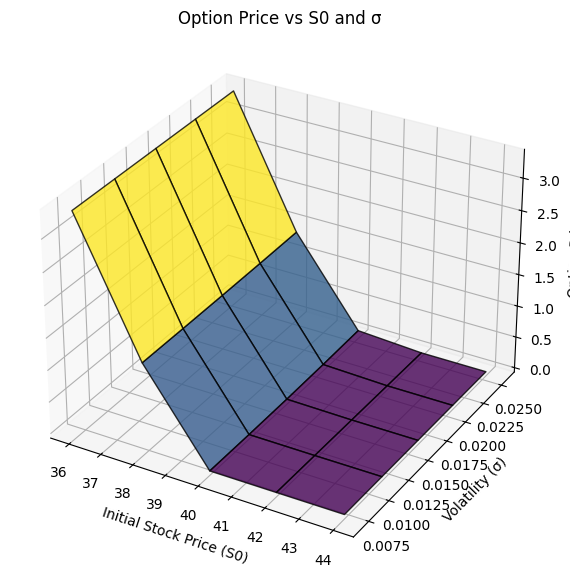

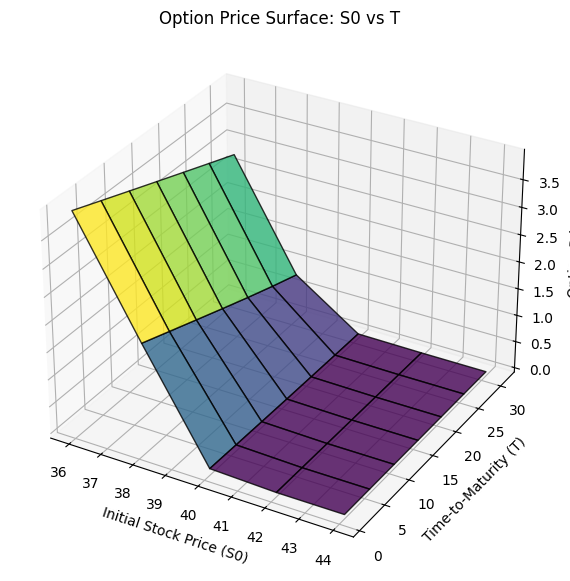

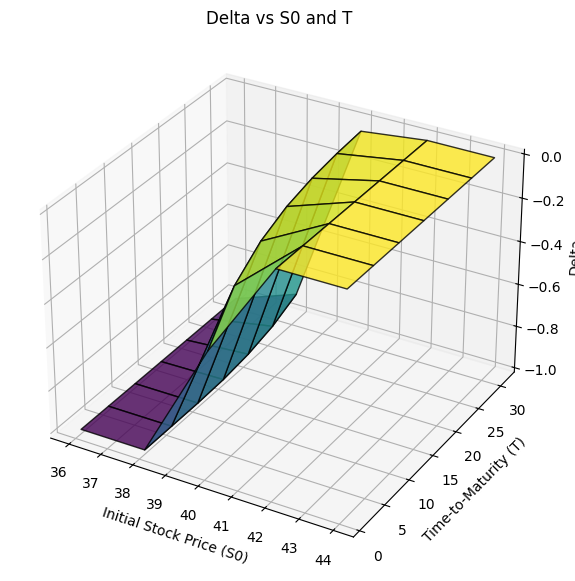

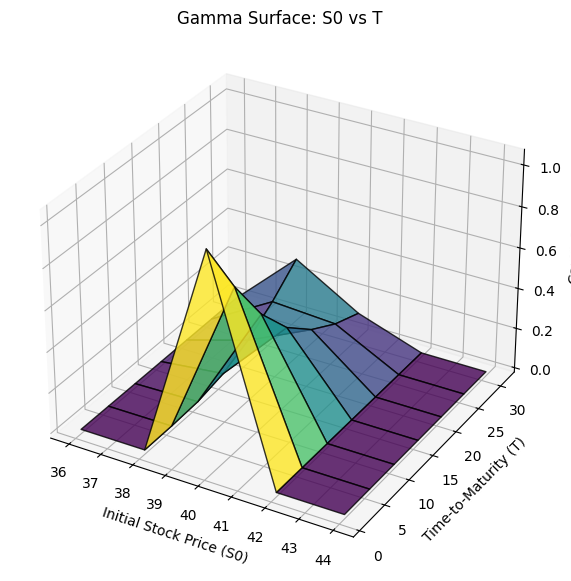

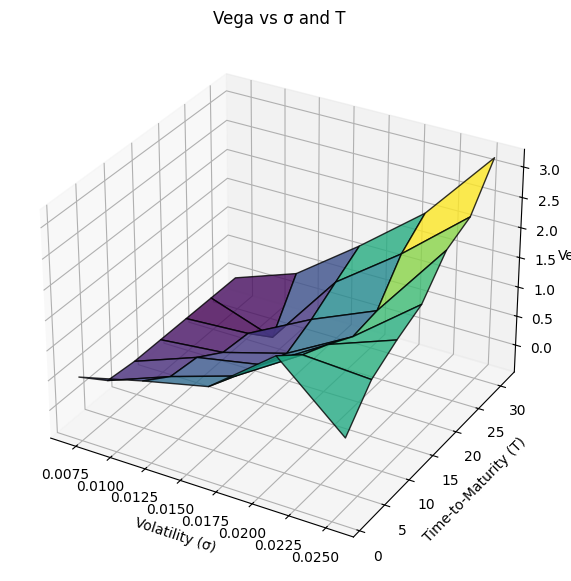

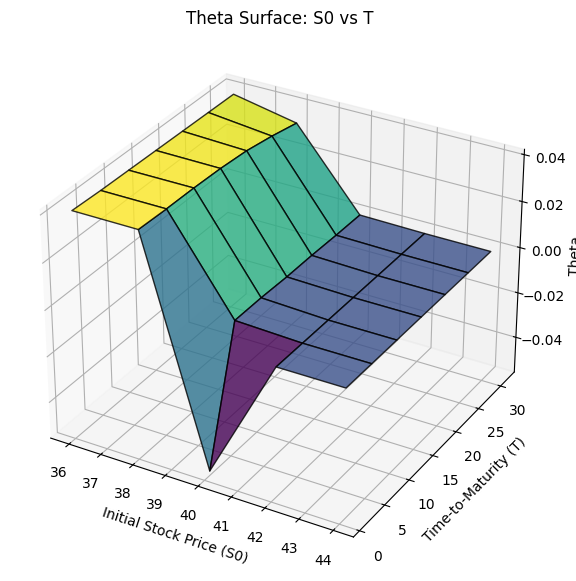

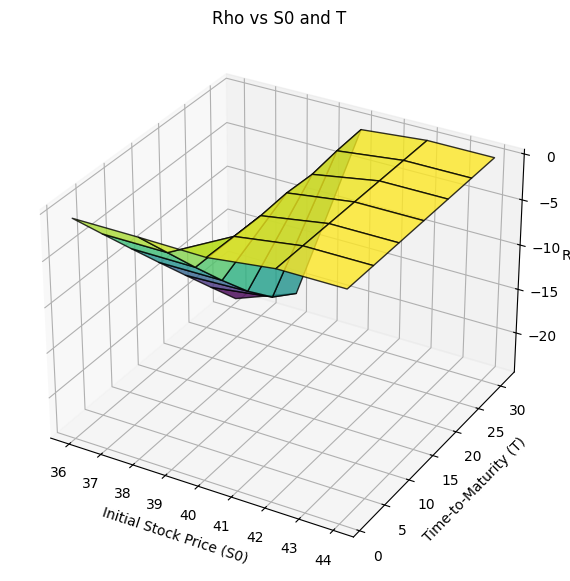

In [98]:
# Generate All Relevant Plots
# 1. Option Price vs Initial Stock Price (S0) and Volatility (σ)
plot_american_options(prices_df, x='S0', y='Vol', z='Price', plot_type='surface',  #'scatter',
                      xlabel='Initial Stock Price (S0)', ylabel='Volatility (σ)', zlabel='Option Price',
                      title='Option Price vs S0 and σ')

# 2. Option Price Surface (S0 vs T)
plot_american_options(prices_df, x='S0', y='TimeToMaturity', z='Price', plot_type='surface',
                      xlabel='Initial Stock Price (S0)', ylabel='Time-to-Maturity (T)', zlabel='Option Price',
                      title='Option Price Surface: S0 vs T')

# 3. Delta vs Initial Stock Price (S0) and Time-to-Maturity (T)
plot_american_options(prices_df, x='S0', y='TimeToMaturity', z='Delta', plot_type='surface',  #'scatter',
                      xlabel='Initial Stock Price (S0)', ylabel='Time-to-Maturity (T)', zlabel='Delta',
                      title='Delta vs S0 and T')

# 4. Gamma Surface (S0 vs T)
plot_american_options(prices_df, x='S0', y='TimeToMaturity', z='Gamma', plot_type='surface',
                      xlabel='Initial Stock Price (S0)', ylabel='Time-to-Maturity (T)', zlabel='Gamma',
                      title='Gamma Surface: S0 vs T')

# 5. Vega vs Volatility (σ) and Time-to-Maturity (T)
plot_american_options(prices_df, x='Vol', y='TimeToMaturity', z='Vega', plot_type='surface',  #'scatter',
                      xlabel='Volatility (σ)', ylabel='Time-to-Maturity (T)', zlabel='Vega',
                      title='Vega vs σ and T')

# 6. Theta Surface (S0 vs T)
plot_american_options(prices_df, x='S0', y='TimeToMaturity', z='Theta', plot_type='surface',
                      xlabel='Initial Stock Price (S0)', ylabel='Time-to-Maturity (T)', zlabel='Theta',
                      title='Theta Surface: S0 vs T')

# 7. Rho vs S0 and T
plot_american_options(prices_df, x='S0', y='TimeToMaturity', z='Rho', plot_type='surface',  #'scatter',
                      xlabel='Initial Stock Price (S0)', ylabel='Time-to-Maturity (T)', zlabel='Rho',
                      title='Rho vs S0 and T')

####Longstaff-Schwartz implementation behaviour

In [108]:
# Parameters for the American Option
option_type = 'put'
S0 = 36.0
strike = 40.0
T = 1.0
M = 50
r = 0.06
div = 0.06
sigma = 0.2
simulations = 100

# Instantiate the American option pricer
american_option = AmericanOptionsLSMC(option_type, S0, strike, T, M, r, div, sigma, simulations)

# Retrieve Monte Carlo price matrix and payoffs
MC_price_matrix = american_option.MCprice_matrix
MC_payoff = american_option.MCpayoff

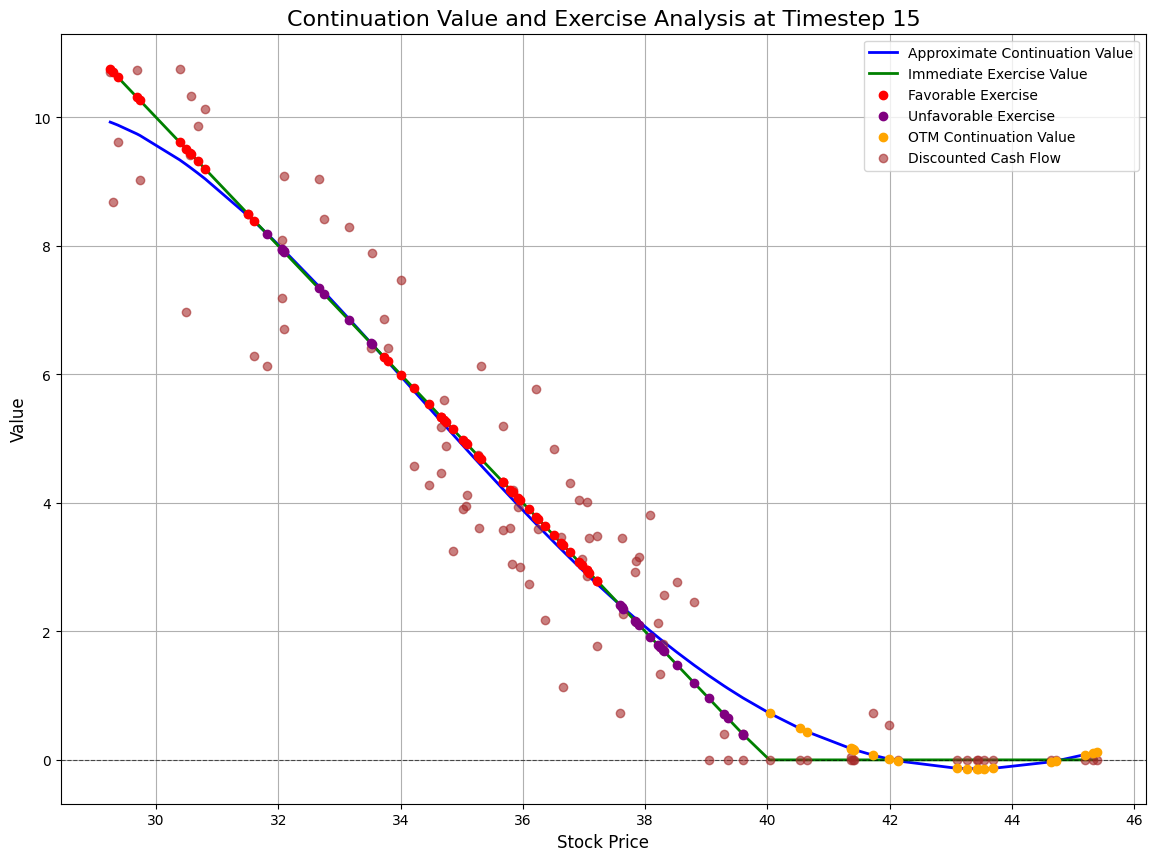

In [110]:
# Continuation value approximation for a single timestep
timestep = 15  # Choose a timestep to visualize
discount = american_option.discount
regression = np.polyfit(MC_price_matrix[timestep, :], MC_payoff[timestep + 1, :] * discount, 5)
approx_continuation_value = np.polyval(regression, MC_price_matrix[timestep, :])

# Immediate exercise value
immediate_exercise_value = MC_payoff[timestep, :]

# Discounted cash flow (future payoff discounted back)
discounted_cash_flow = MC_payoff[timestep + 1, :] * discount

# Exercise decision: favorable exercise if immediate exercise value > continuation value
exercise_decision = immediate_exercise_value > approx_continuation_value

# Identify paths
OTM_paths = MC_price_matrix[timestep, :] >= strike  # Out-of-the-money paths
ITM_paths = ~OTM_paths  # In-the-money paths

# Plotting
plt.figure(figsize=(14, 10))

# Plot approximate continuation value as a solid line
sorted_indices = np.argsort(MC_price_matrix[timestep, :])
plt.plot(MC_price_matrix[timestep, :][sorted_indices],
         approx_continuation_value[sorted_indices],
         label='Approximate Continuation Value', color='blue', linewidth=2)

# Plot immediate exercise value as a solid line
plt.plot(MC_price_matrix[timestep, :][sorted_indices],
         immediate_exercise_value[sorted_indices],
         label='Immediate Exercise Value', color='green', linewidth=2)

# Highlight favorable exercise
plt.scatter(
    MC_price_matrix[timestep, :][exercise_decision & ITM_paths],
    immediate_exercise_value[exercise_decision & ITM_paths],
    color='red', label='Favorable Exercise', zorder=5
)

# Highlight unfavorable exercise
plt.scatter(
    MC_price_matrix[timestep, :][~exercise_decision & ITM_paths],
    immediate_exercise_value[~exercise_decision & ITM_paths],
    color='purple', label='Unfavorable Exercise', zorder=5
)

# Highlight OTM continuation value
plt.scatter(
    MC_price_matrix[timestep, :][OTM_paths],
    approx_continuation_value[OTM_paths],
    color='orange', label='OTM Continuation Value', zorder=5
)

# Plot discounted cash flow
plt.scatter(
    MC_price_matrix[timestep, :],
    discounted_cash_flow,
    color='brown', alpha=0.6, label='Discounted Cash Flow', zorder=4
)

# Plot styling
plt.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.6)
plt.title(f'Continuation Value and Exercise Analysis at Timestep {timestep}', fontsize=16)
plt.xlabel('Stock Price', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


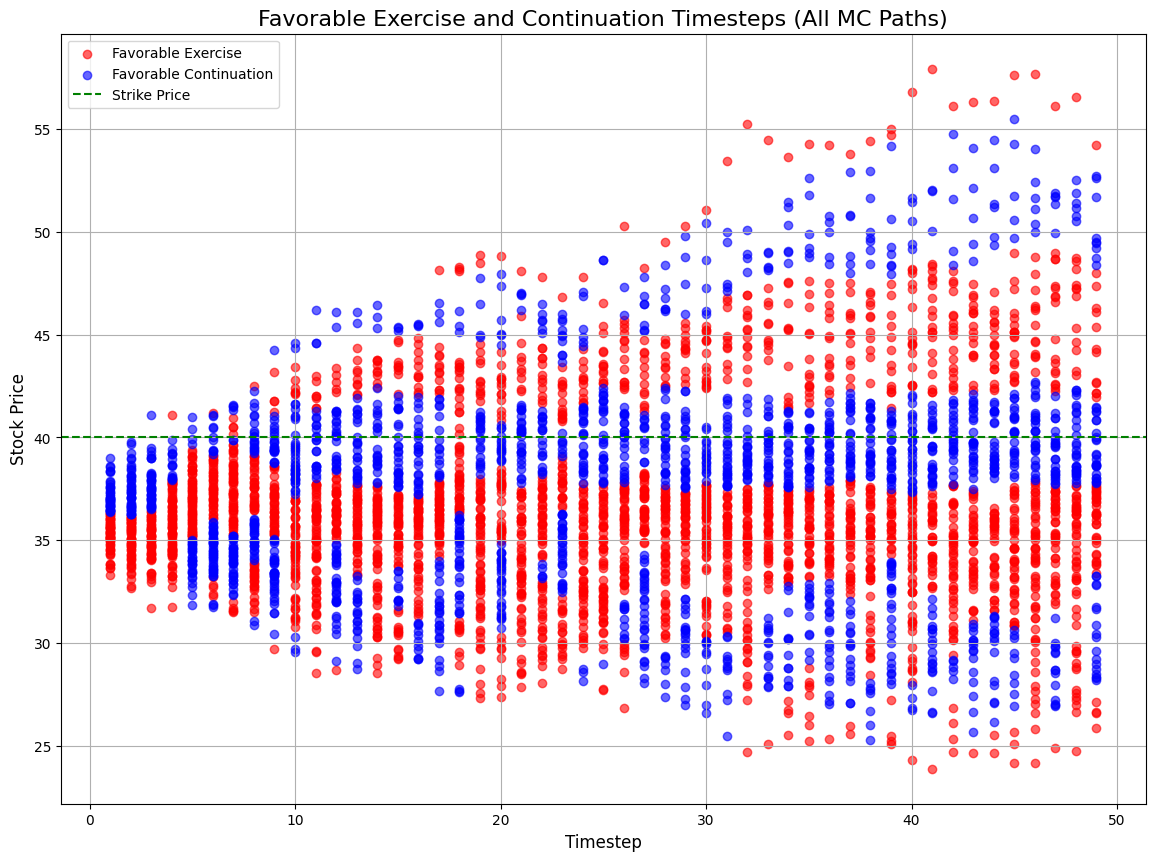

In [107]:
# Prepare data for all Monte Carlo paths
favorable_exercise_prices = []
favorable_exercise_timesteps = []
favorable_continuation_prices = []
favorable_continuation_timesteps = []

# Iterate through all timesteps
for t in range(1, M):  # Exclude the final timestep
    # Approximate continuation value
    regression = np.polyfit(MC_price_matrix[t, :], MC_payoff[t + 1, :] * discount, 5)
    approx_continuation_value = np.polyval(regression, MC_price_matrix[t, :])

    # Immediate exercise value
    immediate_exercise_value = MC_payoff[t, :]

    # Exercise decision
    exercise_decision = immediate_exercise_value > approx_continuation_value

    # Record stock prices and timesteps for favorable exercise
    favorable_exercise_prices.extend(MC_price_matrix[t, :][exercise_decision])
    favorable_exercise_timesteps.extend([t] * sum(exercise_decision))

    # Record stock prices and timesteps for favorable continuation
    favorable_continuation_prices.extend(MC_price_matrix[t, :][~exercise_decision])
    favorable_continuation_timesteps.extend([t] * sum(~exercise_decision))

# Plotting
plt.figure(figsize=(14, 10))

# Plot favorable exercise paths
plt.scatter(favorable_exercise_timesteps, favorable_exercise_prices, color='red', alpha=0.6, label='Favorable Exercise')

# Plot favorable continuation paths
plt.scatter(favorable_continuation_timesteps, favorable_continuation_prices, color='blue', alpha=0.6, label='Favorable Continuation')

# Add strike price as a reference
plt.axhline(strike, color='green', linestyle='--', label='Strike Price', linewidth=1.5)

# Plot styling
plt.title('Favorable Exercise and Continuation Timesteps (All MC Paths)', fontsize=16)
plt.xlabel('Timestep', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


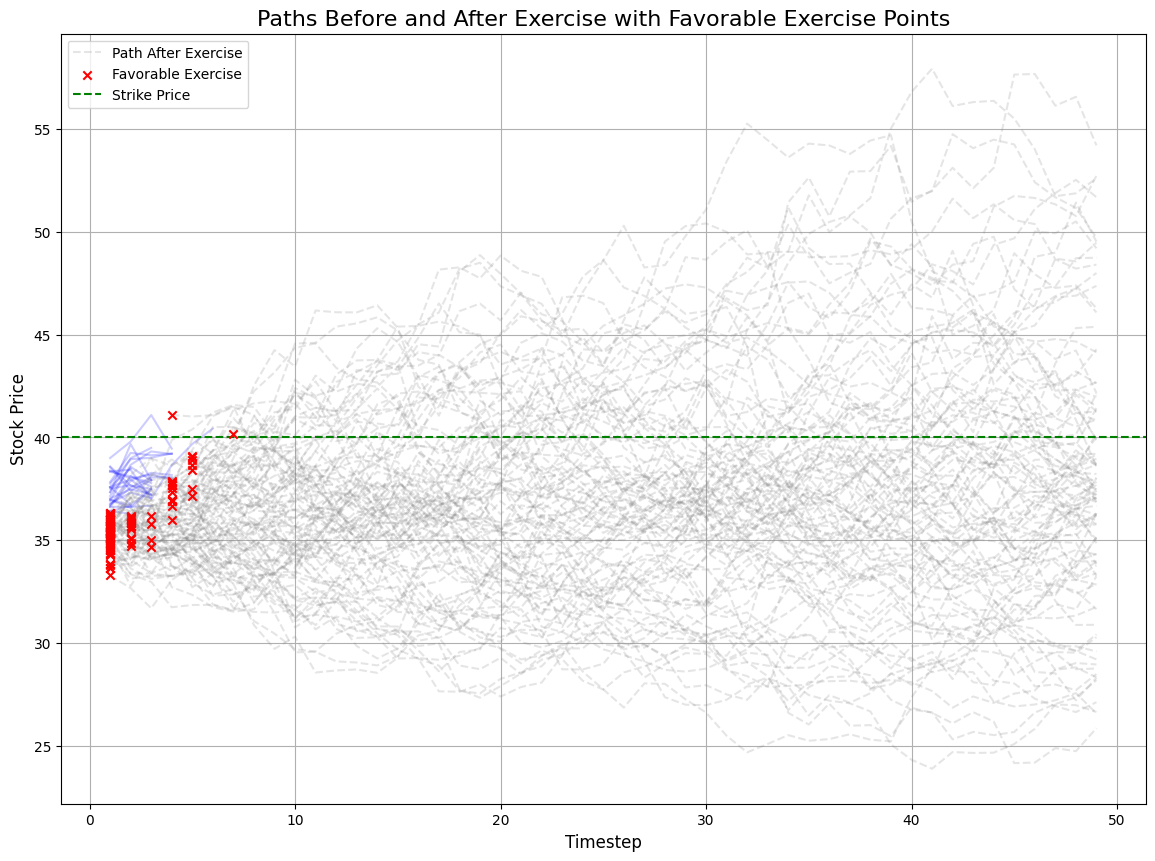

In [105]:
# Prepare data for paths and exercise points
paths_before_exercise = []
paths_after_exercise = []
exercise_points = []

# Iterate through all paths
for i in range(american_option.simulations):
    exercised = False
    path_before = []
    path_after = []
    exercise_point = None

    # Process each timestep
    for t in range(1, M):
        # Approximate continuation value
        regression = np.polyfit(MC_price_matrix[t, :], MC_payoff[t + 1, :] * discount, 5)
        approx_continuation_value = np.polyval(regression, MC_price_matrix[t, i])

        # Immediate exercise value
        immediate_exercise_value = MC_payoff[t, i]

        # Determine if exercise is favorable
        if immediate_exercise_value > approx_continuation_value and not exercised:
            exercised = True
            exercise_point = (t, MC_price_matrix[t, i])  # Record the exercise point

        # Add stock prices to before or after exercise paths
        if not exercised:
            path_before.append((t, MC_price_matrix[t, i]))
        else:
            path_after.append((t, MC_price_matrix[t, i]))

    # Append the paths and exercise point
    paths_before_exercise.append(path_before)
    paths_after_exercise.append(path_after)
    if exercise_point:
        exercise_points.append(exercise_point)

# Plotting
plt.figure(figsize=(14, 10))

# Plot paths before exercise
for path in paths_before_exercise:
    if path:
        timesteps, prices = zip(*path)
        plt.plot(timesteps, prices, color='blue', alpha=0.2, label='Path Before Exercise' if paths_before_exercise.index(path) == 0 else "")

# Plot paths after exercise
for path in paths_after_exercise:
    if path:
        timesteps, prices = zip(*path)
        plt.plot(timesteps, prices, color='gray', linestyle='--', alpha=0.2, label='Path After Exercise' if paths_after_exercise.index(path) == 0 else "")

# Plot exercise points
exercise_timesteps, exercise_prices = zip(*exercise_points)
plt.scatter(exercise_timesteps, exercise_prices, color='red', marker='x', label='Favorable Exercise', zorder=5)

# Add strike price as a reference
plt.axhline(strike, color='green', linestyle='--', label='Strike Price', linewidth=1.5)

# Plot styling
plt.title('Paths Before and After Exercise with Favorable Exercise Points', fontsize=16)
plt.xlabel('Timestep', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()


####Longstaff-Schwartz issues

1. Regression Approximation Problems
* Regression may fail to approximate continuation values accurately, leading to poor exercise decisions.
* Errors in regression may vary across stock price ranges or timesteps.
* Overfitting/underfitting may arise due to inappropriate polynomial degree.
* Plots:
 * Actual vs. Predicted Continuation Values:
 * Errors in Continuation Values:
 * Regression Fit Across Stock Price Ranges:
 * Sensitivity to Polynomial Degree:

In [112]:
def regression_approximation_plots(MC_price_matrix, MC_payoff, discount, t, degree_range):
    # 1. Actual vs. Predicted Continuation Values
    actual_values = MC_payoff[t + 1, :] * discount
    regression = np.polyfit(MC_price_matrix[t, :], actual_values, 5)
    predicted_values = np.polyval(regression, MC_price_matrix[t, :])

    plt.figure(figsize=(14, 6))
    plt.scatter(MC_price_matrix[t, :], actual_values, label='Actual', alpha=0.5, color='blue')
    plt.scatter(MC_price_matrix[t, :], predicted_values, label='Predicted', alpha=0.5, color='red')
    plt.title(f'Regression Approximation at Timestep {t}')
    plt.xlabel('Stock Price')
    plt.ylabel('Continuation Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Errors in Continuation Values
    errors = actual_values - predicted_values
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=30, color='purple', alpha=0.7)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
    plt.title('Errors in Continuation Value Approximation')
    plt.xlabel('Error (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # 3. Regression Fit Across Stock Price Ranges
    plt.figure(figsize=(10, 6))
    plt.scatter(MC_price_matrix[t, :], predicted_values, label='Predicted', alpha=0.6, color='blue')
    plt.scatter(MC_price_matrix[t, :], actual_values, label='Actual', alpha=0.4, color='red')
    plt.plot(np.sort(MC_price_matrix[t, :]), np.polyval(regression, np.sort(MC_price_matrix[t, :])),
             label='Regression Line', color='green')
    plt.title(f'Regression Fit at Timestep {t}')
    plt.xlabel('Stock Price')
    plt.ylabel('Continuation Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4. Sensitivity to Polynomial Degree
    prices = []
    for degree in degree_range:
        regression = np.polyfit(MC_price_matrix[t, :], actual_values, degree)
        predicted_values = np.polyval(regression, MC_price_matrix[t, :])
        prices.append(np.mean(predicted_values))

    plt.figure(figsize=(10, 6))
    plt.plot(degree_range, prices, marker='o', label='Option Price')
    plt.title('Sensitivity to Polynomial Degree')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('Option Price')
    plt.grid(True)
    plt.legend()
    plt.show()


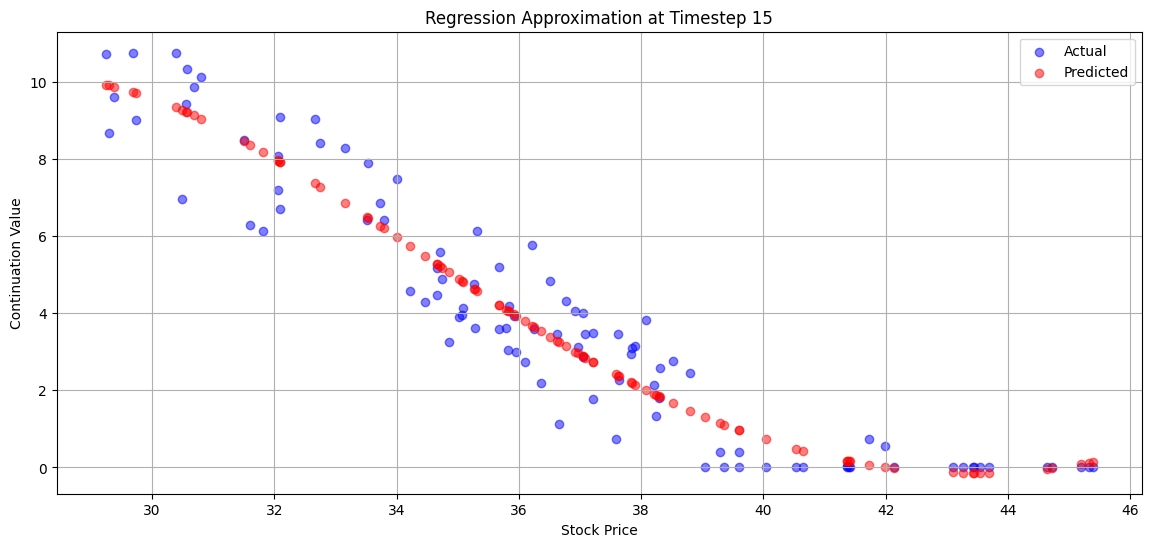

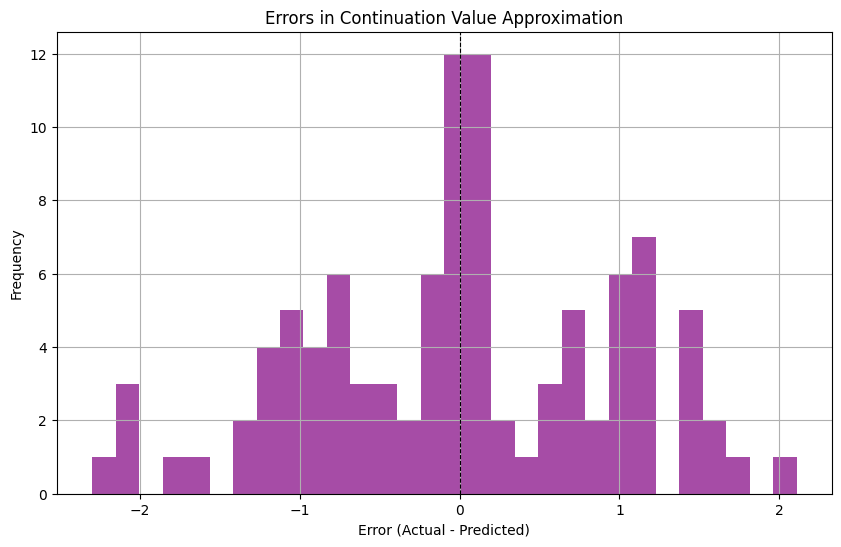

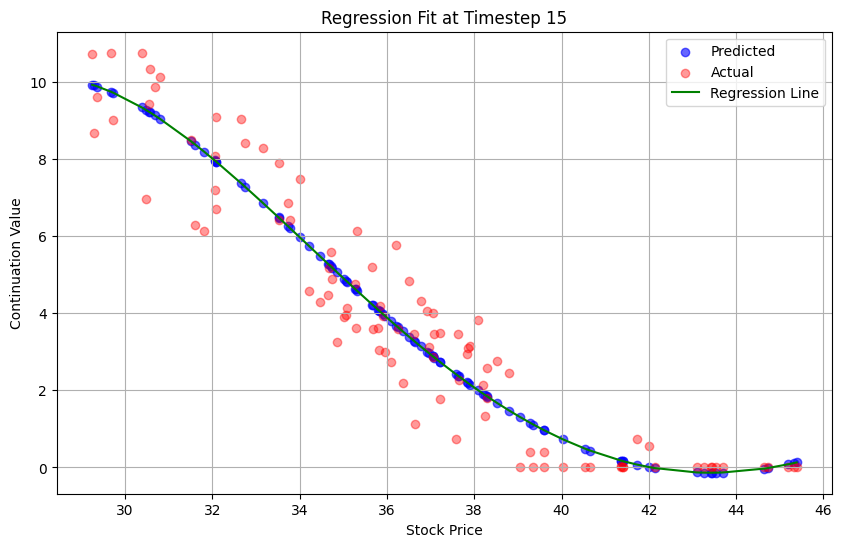

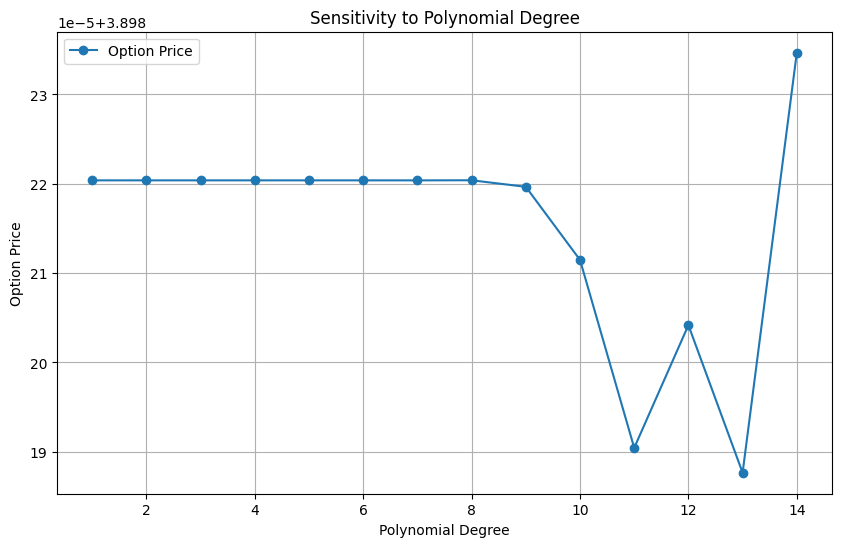

In [121]:
degree_range = np.arange(1,15,1)

regression_approximation_plots(MC_price_matrix, MC_payoff, discount, timestep, degree_range)

2. Exercise Decision Instability
* Exercise decisions may vary inconsistently across MC paths or timesteps.
* Exercise boundaries may oscillate or shift unexpectedly, causing instability.
* Plots:
 * Pathwise Exercise Decisions
 * Exercise Boundary Instability

In [113]:
def exercise_decision_plots(MC_price_matrix, MC_payoff, discount, strike, M):
    # 1. Pathwise Exercise Decisions
    plt.figure(figsize=(14, 10))

    for i in range(MC_price_matrix.shape[1]):  # Iterate over all paths
        plt.plot(range(M + 1), MC_price_matrix[:, i], color='gray', alpha=0.3)

    exercise_points = []
    for t in range(1, M):
        regression = np.polyfit(MC_price_matrix[t, :], MC_payoff[t + 1, :] * discount, 5)
        continuation_value = np.polyval(regression, MC_price_matrix[t, :])
        exercise_decision = MC_payoff[t, :] > continuation_value
        exercise_points.extend([(t, MC_price_matrix[t, i]) for i in range(MC_price_matrix.shape[1]) if exercise_decision[i]])

    if exercise_points:
        exercise_timesteps, exercise_prices = zip(*exercise_points)
        plt.scatter(exercise_timesteps, exercise_prices, color='red', marker='x', label='Exercise Points')

    plt.axhline(strike, color='green', linestyle='--', label='Strike Price')
    plt.title('MC Paths and Exercise Decisions')
    plt.xlabel('Timestep')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Exercise Boundary Instability
    exercise_boundaries = []
    for t in range(1, M):
        regression = np.polyfit(MC_price_matrix[t, :], MC_payoff[t + 1, :] * discount, 5)
        continuation_value = np.polyval(regression, MC_price_matrix[t, :])
        exercise_decision = MC_payoff[t, :] > continuation_value
        boundary = np.min(MC_price_matrix[t, exercise_decision]) if np.any(exercise_decision) else None
        exercise_boundaries.append((t, boundary))

    boundaries = [(t, b) for t, b in exercise_boundaries if b is not None]
    if boundaries:
        timesteps, boundary_prices = zip(*boundaries)
        plt.figure(figsize=(10, 6))
        plt.plot(timesteps, boundary_prices, marker='o', label='Exercise Boundary')
        plt.axhline(strike, color='green', linestyle='--', label='Strike Price')
        plt.title('Exercise Boundary Instability')
        plt.xlabel('Timestep')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.grid(True)
        plt.show()


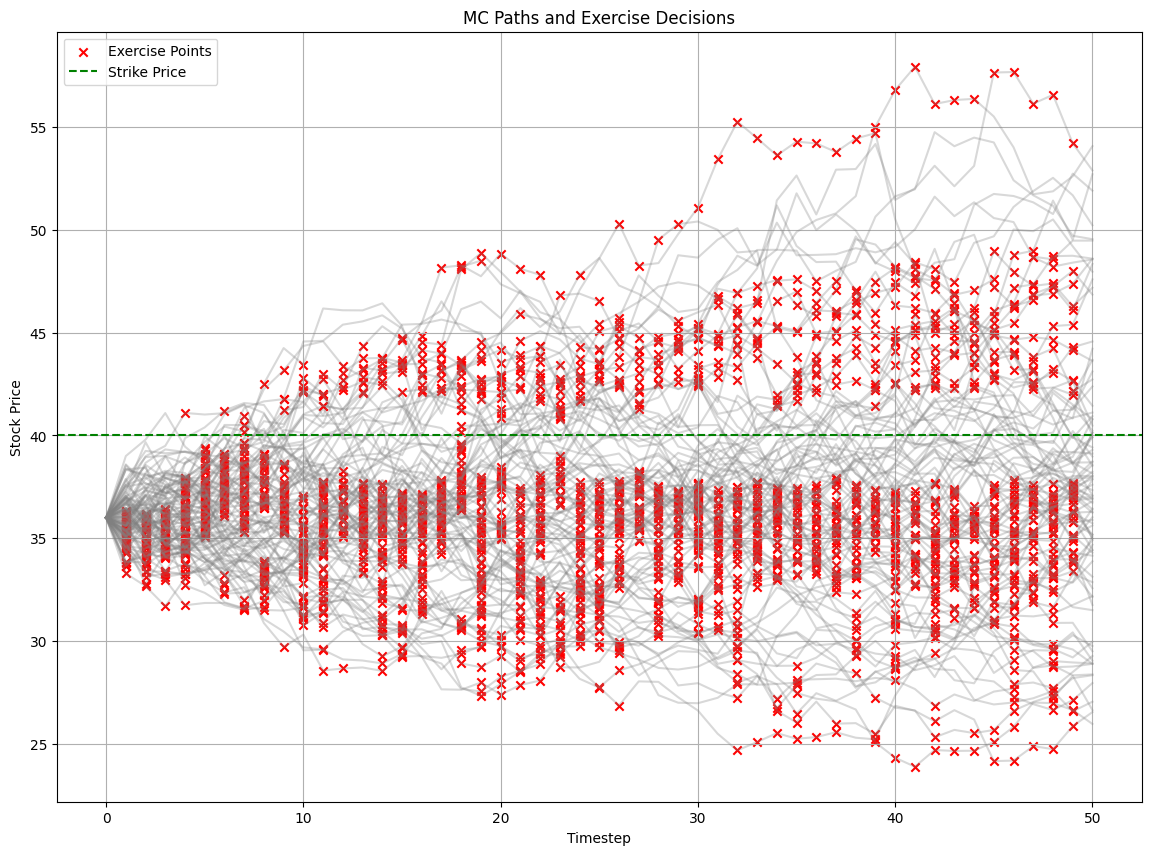

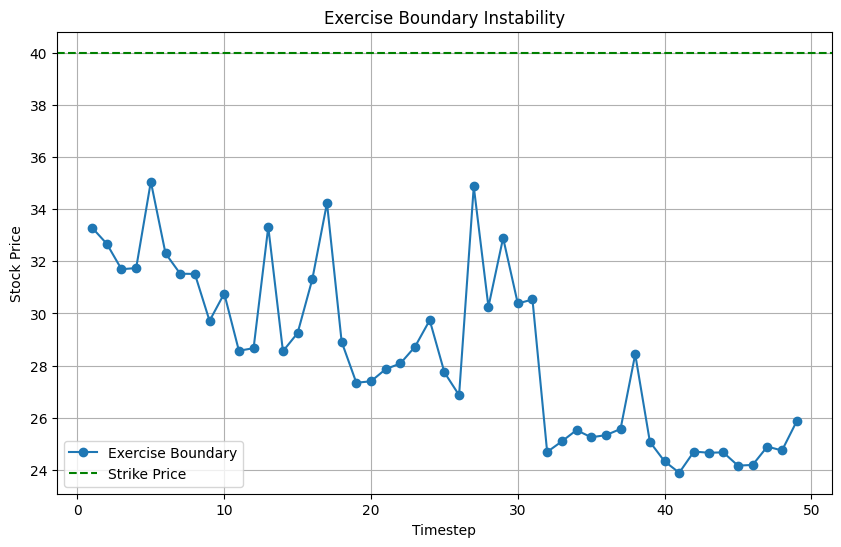

In [116]:
exercise_decision_plots(MC_price_matrix, MC_payoff, discount, strike, M)

3. Convergence Problems
* LS requires a large number of MC paths for stable results.
* Insufficient paths can cause unstable option prices.
* Plots:
 * Convergence of Option Prices.

In [122]:
def convergence_plot(option_type, S0, strike, T, M, r, div, sigma):
    num_simulations = [100, 500, 1000, 5000, 10000, 50000, 100000]
    option_prices = []

    for sims in num_simulations:
        option = AmericanOptionsLSMC(option_type, S0, strike, T, M, r, div, sigma, sims)
        option_prices.append(option.price)

    plt.figure(figsize=(10, 6))
    plt.plot(num_simulations, option_prices, marker='o', label='Option Price')
    plt.title('Convergence of Option Price with Number of Simulations')
    plt.xlabel('Number of Simulations')
    plt.ylabel('Option Price')
    plt.grid(True)
    plt.legend()
    plt.show()


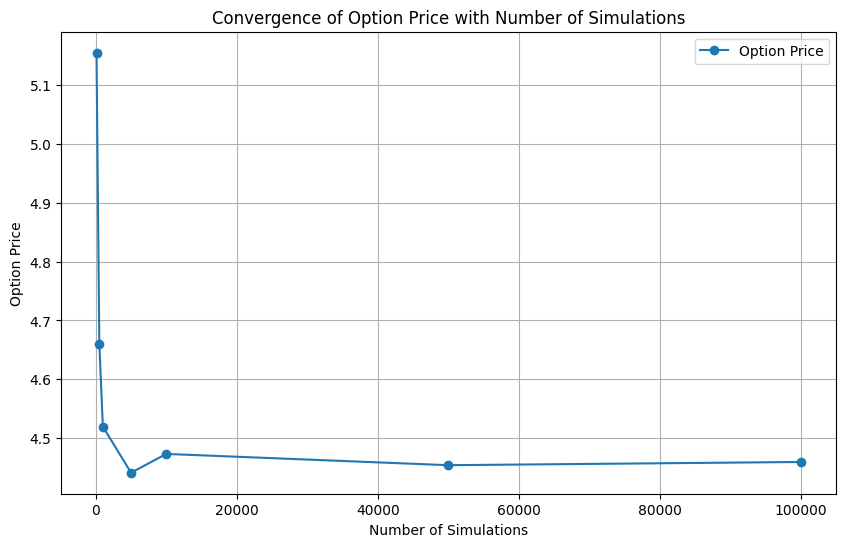

In [123]:
convergence_plot(option_type, S0, strike, T, M, r, div, sigma)

####Roger's Upper Bound



In [132]:
def rogers_upper_bound(simulated_paths, payoff_function, r, T, M, strike):
    """
    Computes Rogers' upper bound for an American option price.

    Parameters:
    - simulated_paths: ndarray of shape (num_paths, num_timesteps), simulated stock prices.
    - payoff_function: function, computes the option payoff given stock prices.
    - r: float, risk-free rate.
    - T: float, time to maturity.
    - M: int, number of timesteps.
    - strike: float, option strike.

    Returns:
    - upper_bound: float, computed upper bound.
    """
    num_paths, num_timesteps = simulated_paths.shape
    dt = T / M
    discount = np.exp(-r * dt)

    # Initialize martingale and continuation value approximations
    martingale = np.zeros((num_paths, num_timesteps))
    continuation_value = np.zeros((num_paths, num_timesteps))

    # Backward induction to compute continuation value approximation
    for t in range(num_timesteps - 2, -1, -1):  # Exclude the last step
        stock_prices = simulated_paths[:, t]
        future_payoffs = payoff_function(simulated_paths[:, t + 1])

        # Approximate continuation value using regression (example: quadratic fit)
        coeffs = np.polyfit(stock_prices, future_payoffs * discount, deg=2)
        continuation_value[:, t] = np.polyval(coeffs, stock_prices)

        # Update martingale
        martingale[:, t] = continuation_value[:, t] * discount

    # Compute the upper bound for each path
    upper_bound_values = []
    for i in range(num_paths):
        path = simulated_paths[i]
        payoffs = payoff_function(path)
        discounted_payoffs = payoffs * np.exp(-r * np.arange(num_timesteps) * dt)
        upper_bound_values.append(np.max(discounted_payoffs - martingale[i, :] + martingale[i, 0]))

    # Average over all paths
    upper_bound = np.mean(upper_bound_values)
    return upper_bound



In [133]:
def payoff_function(stock_prices):
    """
    Payoff function for a put option.
    """
    strike_price = 40
    return np.maximum(strike - stock_prices, 0)

In [134]:
# Simulation Parameters
option_type = 'put'
S0 = 36.0
strike = 40.0
T = 1.0
M = 50
r = 0.06
div = 0.06
sigma = 0.2
simulations = 10000

In [136]:
# Create Longstaff-Schwartz American option implementation object
american_option = AmericanOptionsLSMC(option_type, S0, strike, T, M, r, div, sigma, simulations)

In [137]:
# Generate simulated stock price paths
simulated_paths = american_option.MCprice_matrix

# Compute lower bound using Longstaff-Schwartz
lower_bound = american_option.price

# Compute upper bound using Rogers' method
upper_bound = rogers_upper_bound(simulated_paths, payoff_function, r, T, M, strike)

# Print results
print(f"Longstaff-Schwartz Lower Bound: {lower_bound}")
print(f"Rogers' Upper Bound: {upper_bound}")

Longstaff-Schwartz Lower Bound: 4.473117701771221
Rogers' Upper Bound: 12.206361664995036


In [138]:
def rogers_upper_bound_pathwise(simulated_paths, payoff_function, r, T, M):
    """
    Computes Rogers' upper bound for each path of an American option price.

    Parameters:
    - simulated_paths: ndarray of shape (num_paths, num_timesteps), simulated stock prices.
    - payoff_function: function, computes the option payoff given stock prices.
    - r: float, risk-free rate.
    - T: float, time to maturity.
    - M: int, number of timesteps.

    Returns:
    - upper_bounds: ndarray of shape (num_paths,), computed upper bounds for each path.
    """
    num_paths, num_timesteps = simulated_paths.shape
    dt = T / M
    discount = np.exp(-r * dt)

    # Initialize martingale and continuation value approximations
    martingale = np.zeros_like(simulated_paths)
    continuation_value = np.zeros_like(simulated_paths)

    # Backward induction to compute continuation value approximation
    for t in range(num_timesteps - 2, -1, -1):
        stock_prices = simulated_paths[:, t]
        future_payoffs = payoff_function(simulated_paths[:, t + 1])

        # Approximate continuation value using regression
        coeffs = np.polyfit(stock_prices, future_payoffs * discount, deg=2)
        continuation_value[:, t] = np.polyval(coeffs, stock_prices)

        # Update martingale
        martingale[:, t] = continuation_value[:, t] * discount

    # Compute the upper bound for each path
    upper_bounds = []
    for i in range(num_paths):
        path = simulated_paths[i]
        payoffs = payoff_function(path)
        discounted_payoffs = payoffs * np.exp(-r * np.arange(num_timesteps) * dt)
        upper_bounds.append(np.max(discounted_payoffs - martingale[i, :] + martingale[i, 0]))

    return np.array(upper_bounds)

def compare_bounds_across_paths(american_option, payoff_function):
    """
    Compares Rogers' Upper Bound and Longstaff-Schwartz Lower Bound across MC paths.

    Parameters:
    - american_option: AmericanOptionsLSMC instance.
    - payoff_function: function, computes the option payoff given stock prices.
    """
    # Generate simulated stock price paths
    simulated_paths = american_option.MCprice_matrix

    # Compute Longstaff-Schwartz lower bound (pathwise)
    lower_bounds = np.zeros(simulated_paths.shape[0])
    for i in range(simulated_paths.shape[0]):
        path = simulated_paths[i]
        for t in range(american_option.M):
            if payoff_function(path[t]) > np.mean(payoff_function(simulated_paths[:, t + 1])):
                lower_bounds[i] = payoff_function(path[t]) * np.exp(-american_option.r * t * american_option.time_unit)
                break

    # Compute Rogers' upper bound (pathwise)
    upper_bounds = rogers_upper_bound_pathwise(
        simulated_paths=simulated_paths,
        payoff_function=payoff_function,
        r=american_option.r,
        T=american_option.T,
        M=american_option.M
    )

    # Plot bounds across MC paths
    path_indices = np.arange(len(lower_bounds))

    plt.figure(figsize=(14, 8))
    plt.plot(path_indices, lower_bounds, label='Longstaff-Schwartz Lower Bound', color='blue', alpha=0.7)
    plt.plot(path_indices, upper_bounds, label='Rogers Upper Bound', color='red', alpha=0.7)
    plt.title('Comparison of Longstaff-Schwartz and Rogers Bounds Across MC Paths', fontsize=16)
    plt.xlabel('Path Index', fontsize=12)
    plt.ylabel('Option Price', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.show()

    # Print summary statistics
    print(f"Average Longstaff-Schwartz Lower Bound: {np.mean(lower_bounds):.4f}")
    print(f"Average Rogers' Upper Bound: {np.mean(upper_bounds):.4f}")
    print(f"Gap (Upper Bound - Lower Bound): {np.mean(upper_bounds) - np.mean(lower_bounds):.4f}")


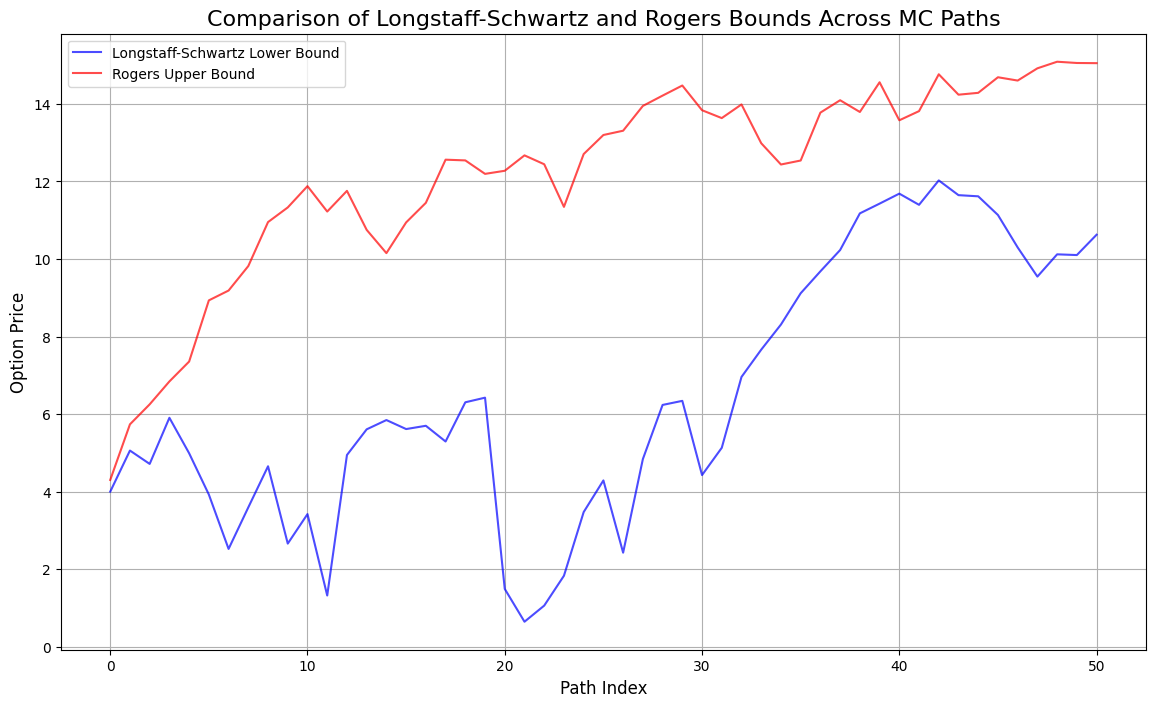

Average Longstaff-Schwartz Lower Bound: 6.4609
Average Rogers' Upper Bound: 12.2064
Gap (Upper Bound - Lower Bound): 5.7455


In [139]:
compare_bounds_across_paths(american_option, payoff_function)

####To Do
* Add more underlying model dynamics, apart from BS.
* Extend to correlated hybrids.
* Add other (more exotic) option payoffs.
* Add tree version of LS.
* Modify prices, Greeks, continuation value approximation, favourable exercise and favourable continuation visualizations into functions to plot for different option payoffs.
* Add flavours of MC.
* Add flavours of regression.


####References

* Longstaff-Schwartz (2001): "Valuing American Options by Simulation: A Simple Least-Squares Approach."
* Jesus Perez Colino's Git repo: https://github.com/jpcolino/IPython_notebooks/tree/master
* luphord's Git repo: https://github.com/luphord/longstaff_schwartz/tree/master